In [1]:
from warnings import simplefilter

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import torch
from matplotlib.ticker import ScalarFormatter
from sklearn.compose import TransformedTargetRegressor
from sklearn.ensemble import HistGradientBoostingRegressor, RandomForestRegressor
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVR
from torch.utils.data import DataLoader, TensorDataset

from pytorch_helpers import MLP
from sklearn_helpers import get_column_transformer, get_preprocessor, show_coefficients

simplefilter(action="ignore", category=FutureWarning)
sns.set_theme(style="whitegrid")
pd.set_option("display.precision", 3)
pd.set_option("display.max_columns", 100)


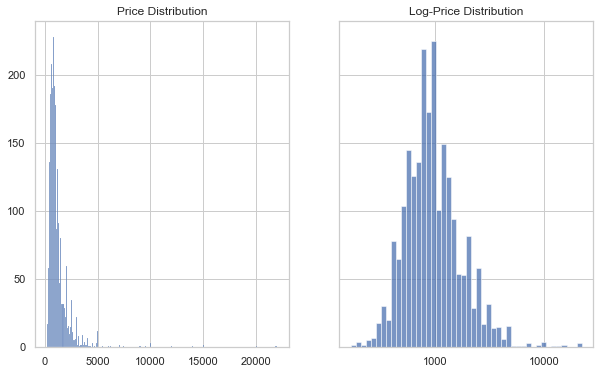

In [2]:
# SECTION: Plot Price and Log-Price Distribution
listings_df = pd.read_pickle("../data-clean/listings_subset.pkl")

fig, axes = plt.subplots(ncols=2, figsize=(10, 6), sharey=True)
ax1, ax2 = axes.flat

sns.histplot(listings_df["price"], ax=ax1).set(
    title="Price Distribution", xlabel="", ylabel=""
)

sns.histplot(listings_df["price"], log_scale=True, ax=ax2).set(
    title="Log-Price Distribution", xlabel="", ylabel=""
)

ax2.xaxis.set_major_formatter(ScalarFormatter())

fig.savefig("../term-paper/images/price_distribution.png")
plt.show()



In [3]:
# SECTION: Model Comparison for different Number of Features
classical_models_rfe_results = pd.read_pickle(
    "../results-pickle/classical_models_rfe_results.pkl"
)
neural_network_rfe_results = pd.read_pickle(
    "../results-pickle/neural_network_rfe_results.pkl"
)

complete_rfe_results = pd.concat(
    [
        classical_models_rfe_results,
        neural_network_rfe_results,
    ]
).sort_values("mae_val")

complete_rfe_results.to_pickle("../results-pickle/complete_rfe_results.pkl")


In [4]:
complete_rfe_results


,mae_train,mae_val,r2_train,r2_val,mse_train,mse_val,hyperparam_keys,hyperparam_values,log_y,feature_selector,num_features,selected_features
Ridge,371.355,380.299,0.331,0.363,1.102e+06,1.122e+06,alpha,14,True,None,59,"[accommodates, availability_30, cnn_pretrained..."
Ridge,371.978,380.527,0.330,0.361,1.104e+06,1.124e+06,alpha,14,True,RFE,50,"[accommodates, availability_30, cnn_pretrained..."
LinearRegression,369.673,381.297,0.334,0.362,1.097e+06,1.122e+06,None,None,True,RFE,50,"[accommodates, availability_30, cnn_pretrained..."
Ridge,376.545,383.208,0.318,0.355,1.122e+06,1.132e+06,alpha,14,True,RFE,25,"[accommodates, availability_30, cnn_pretrained..."
LinearRegression,376.188,383.845,0.321,0.356,1.118e+06,1.129e+06,None,None,True,RFE,25,"[accommodates, availability_30, cnn_pretrained..."
HistGradientBoostingRegressor,247.234,383.978,0.764,0.401,3.877e+05,1.050e+06,"[min_samples_leaf, max_leaf_nodes, max_iter, m...","[4, 30, 40, 18, 0.09]",True,None,59,"[accommodates, availability_30, cnn_pretrained..."
HistGradientBoostingRegressor,258.241,384.043,0.742,0.408,4.233e+05,1.034e+06,"[min_samples_leaf, max_leaf_nodes, max_iter, m...","[4, 30, 40, 18, 0.09]",True,RFE,25,"[accommodates, availability_30, cnn_pretrained..."
LinearRegression,370.543,384.603,0.335,0.359,1.095e+06,1.126e+06,None,None,True,None,59,"[accommodates, availability_30, cnn_pretrained..."
HistGradientBoostingRegressor,246.814,386.296,0.771,0.391,3.753e+05,1.063e+06,"[min_samples_leaf, max_leaf_nodes, max_iter, m...","[4, 30, 40, 18, 0.09]",True,RFE,50,"[accommodates, availability_30, cnn_pretrained..."
Ridge,387.610,393.012,0.308,0.339,1.139e+06,1.151e+06,alpha,48,True,RFE,10,"[accommodates, availability_30, cnn_pretrained..."


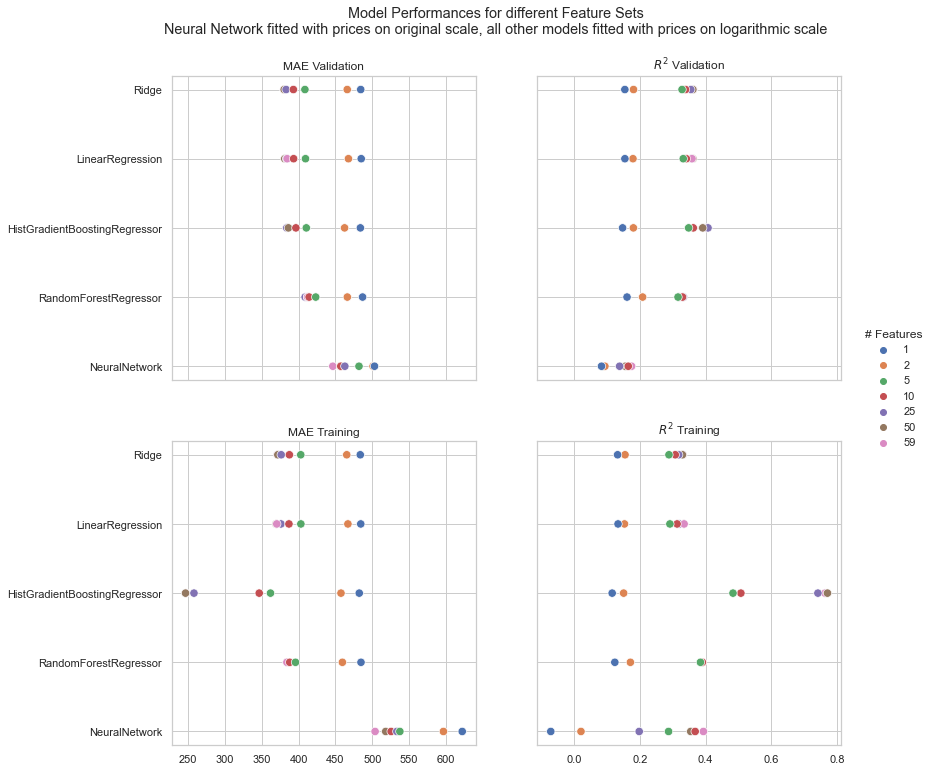

In [5]:
plot_data = complete_rfe_results.astype({"num_features": "category"})

# sharex="col", sharey="row" is amazing :)
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 12), sharex="col", sharey=True)
ax1, ax2, ax3, ax4 = axes.flat

sns.scatterplot(
    data=plot_data,
    x="mae_val",
    y=plot_data.index,
    hue="num_features",
    markers=["s", "o"],
    s=70,
    ax=ax1,
    legend=False,
).set(title="MAE Validation", xlabel="")

sns.scatterplot(
    data=plot_data,
    x="mae_train",
    y=plot_data.index,
    hue="num_features",
    markers=["s", "o"],
    s=70,
    ax=ax3,
    legend=False,
).set(title="MAE Training", xlabel="")

sns.scatterplot(
    data=plot_data,
    x="r2_val",
    y=plot_data.index,
    hue="num_features",
    markers=["s", "o"],
    s=70,
    ax=ax2,
    legend=True,
).set(title=r"$R^2$ Validation", xlabel="")

lgd = ax2.legend(title="# Features", bbox_to_anchor=(1.3, 0.2), frameon=False)

sns.scatterplot(
    data=plot_data,
    x="r2_train",
    y=plot_data.index,
    hue="num_features",
    markers=["s", "o"],
    s=70,
    ax=ax4,
    legend=False,
).set(title=r"$R^2$ Training", xlabel="")

sup = fig.suptitle(
    "Model Performances for different Feature Sets\n"
    "Neural Network fitted with prices on original scale, all other models fitted with prices on logarithmic scale"
)

fig.subplots_adjust(top=0.9)
fig.savefig(
    "../term-paper/images/model_comparison.png",
    bbox_extra_artists=(lgd, sup),
    bbox_inches="tight",
)



In [6]:
# SUBSECTION: Load Data from Training, Validation and Test Set
X_train_val = pd.read_pickle("../data-clean/X_train_val.pkl")
y_train_val = pd.read_pickle("../data-clean/y_train_val.pkl")

X_test = pd.read_pickle("../data-clean/X_test.pkl")
y_test = pd.read_pickle("../data-clean/y_test.pkl")


In [7]:
# SUBSECTION: Coefficient Plot for Linear Regression
column_transformer = get_column_transformer()
rfe = RFE(SVR(kernel="linear"), n_features_to_select=25, step=0.5)
preprocessor = get_preprocessor(column_transformer, rfe)

coef_model = LinearRegression()
pipeline = make_pipeline(preprocessor, coef_model)
log_transform = TransformedTargetRegressor(pipeline, func=np.log, inverse_func=np.exp)

log_transform.fit(X_train_val, y_train_val)
coefs = show_coefficients(log_transform)


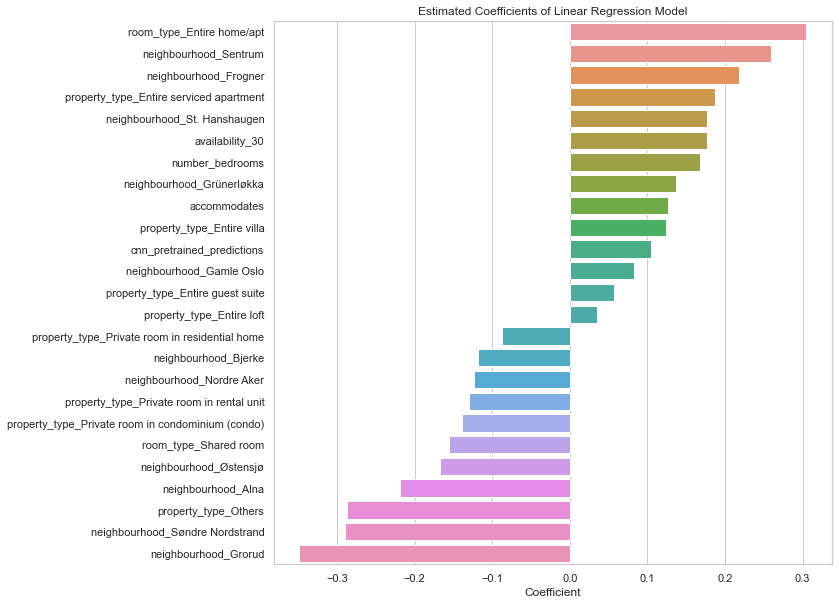

In [8]:
fig, ax = plt.subplots(figsize=(10, 10))

sns.barplot(data=coefs, x="coefficient", y="feature", ax=ax).set(
    title="Estimated Coefficients of Linear Regression Model",
    ylabel="",
    xlabel="Coefficient",
)

fig.savefig("../term-paper/images/coefficient_plot.png", bbox_inches="tight")

plt.show()


In [9]:
# SECTION: Evaluate Performance on Test Set for Best Model of each Class
# NOTE: Best Models chosen by lowest MAE
best_models = (
    complete_rfe_results.groupby(complete_rfe_results.index)
    .apply(lambda x: x.nsmallest(1, "mae_val"))
    .sort_values("mae_val")
)

best_models


,,mae_train,mae_val,r2_train,r2_val,mse_train,mse_val,hyperparam_keys,hyperparam_values,log_y,feature_selector,num_features,selected_features
Ridge,Ridge,371.355,380.299,0.331,0.363,1.102e+06,1.122e+06,alpha,14,True,None,59,"[accommodates, availability_30, cnn_pretrained..."
LinearRegression,LinearRegression,369.673,381.297,0.334,0.362,1.097e+06,1.122e+06,None,None,True,RFE,50,"[accommodates, availability_30, cnn_pretrained..."
HistGradientBoostingRegressor,HistGradientBoostingRegressor,247.234,383.978,0.764,0.401,3.877e+05,1.050e+06,"[min_samples_leaf, max_leaf_nodes, max_iter, m...","[4, 30, 40, 18, 0.09]",True,None,59,"[accommodates, availability_30, cnn_pretrained..."
RandomForestRegressor,RandomForestRegressor,385.275,408.941,0.390,0.333,1.003e+06,1.177e+06,"[n_estimators, min_samples_leaf, max_depth]","[6, 7, 4]",True,RFE,25,"[accommodates, availability_30, cnn_pretrained..."
NeuralNetwork,NeuralNetwork,503.803,446.493,0.394,0.175,9.030e+05,1.873e+06,"[batch_size, num_epochs, dropout_probability, ...","[128, 200, 0.5, 0.01, None, 0]",False,RFE,59,"[accommodates, availability_30, cnn_pretrained..."


In [10]:
# SUBSECTION: Best Linear Regression Model
column_transformer = get_column_transformer()
rfe = RFE(SVR(kernel="linear"), n_features_to_select=50, step=0.5)
preprocessor = get_preprocessor(column_transformer, rfe)

linearreg = LinearRegression()
pipeline = make_pipeline(preprocessor, linearreg)
log_transform = TransformedTargetRegressor(pipeline, func=np.log, inverse_func=np.exp)

log_transform.fit(X_train_val, y_train_val)
linearreg_predictions = log_transform.predict(X_test)


In [11]:
# SUBSECTION: Best Ridge Model
column_transformer = get_column_transformer()

ridge = Ridge(alpha=14)
pipeline = make_pipeline(column_transformer, ridge)
log_transform = TransformedTargetRegressor(pipeline, func=np.log, inverse_func=np.exp)

log_transform.fit(X_train_val, y_train_val)
ridge_predictions = log_transform.predict(X_test)


In [12]:
# SUBSECTION: Best Random Forest Model
column_transformer = get_column_transformer()
rfe = RFE(SVR(kernel="linear"), n_features_to_select=25, step=0.5)
preprocessor = get_preprocessor(column_transformer, rfe)

randomforest = RandomForestRegressor(n_estimators=6, min_samples_leaf=7, max_depth=4)
pipeline = make_pipeline(preprocessor, randomforest)
log_transform = TransformedTargetRegressor(pipeline, func=np.log, inverse_func=np.exp)

log_transform.fit(X_train_val, y_train_val)
randomforest_predictions = log_transform.predict(X_test)


In [13]:
# SUBSECTION: Best HistGradientBoosting Model
column_transformer = get_column_transformer()

histgradientboosting = HistGradientBoostingRegressor(
    min_samples_leaf=4, max_leaf_nodes=30, max_iter=40, max_depth=18, learning_rate=0.09
)
pipeline = make_pipeline(column_transformer, histgradientboosting)
log_transform = TransformedTargetRegressor(pipeline, func=np.log, inverse_func=np.exp)

log_transform.fit(X_train_val, y_train_val)
histgradientboosting_predictions = log_transform.predict(X_test)


In [14]:
# SUBSECTION: Best Neural Network Model
column_transformer = get_column_transformer()
column_transformer.fit(X_train_val)

X_tensor_test = torch.tensor(column_transformer.transform(X_test).astype(np.float32))
y_tensor_test = torch.tensor(y_test.values.astype(np.float32))
testset = TensorDataset(X_tensor_test, y_tensor_test)
testloader = DataLoader(testset, batch_size=X_tensor_test.shape[0], shuffle=False)

in_features = X_tensor_test.shape[1]
hidden_features_list = [64, 128, 256, 128, 64, 8]
dropout_prob = 0.5
use_skip_connections = True

mlp = MLP(in_features, hidden_features_list, dropout_prob, use_skip_connections)
mlp.load_state_dict(torch.load("mlp_weights_None.pt"))
mlp.eval()

with torch.no_grad():
    X_nn, y_nn = next(iter(testloader))
    mlp_predictions = mlp(X_nn).squeeze()


In [15]:
# SUBSECTION: Add Ensemble Predictions
top2_average = np.mean([ridge_predictions, linearreg_predictions], axis=0)

top3_average = np.mean(
    [ridge_predictions, linearreg_predictions, histgradientboosting_predictions], axis=0
)

top4_average = np.mean(
    [
        ridge_predictions,
        linearreg_predictions,
        histgradientboosting_predictions,
        randomforest_predictions,
    ],
    axis=0,
)

top5_average = np.mean(
    [
        ridge_predictions,
        linearreg_predictions,
        histgradientboosting_predictions,
        randomforest_predictions.shape,
        mlp_predictions.detach().numpy(),
    ],
    axis=0,
)


/opt/homebrew/Caskroom/miniforge/base/envs/airbnb/lib/python3.9/site-packages/numpy/core/_methods.py:163: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asanyarray(a)


In [16]:
# SECTION: Evaluate All Predictions from Test Set
df_index = [
    "Linear Regression",
    "Ridge",
    "Random Forest",
    "HistGradientBoosting",
    "Neural Network",
    "Top2 Average",
    "Top3 Average",
    "Top4 Average",
    "Top5 Average",
]

testset_df_list = []

for predictions in [
    linearreg_predictions,
    ridge_predictions,
    randomforest_predictions,
    histgradientboosting_predictions,
    mlp_predictions.detach().numpy(),
    top2_average,
    top3_average,
    top4_average,
    top5_average,
]:

    temp_df = pd.DataFrame(
        {
            "MAE": [mean_absolute_error(y_test, predictions)],
            "R2": [r2_score(y_test, predictions)],
            "MSE": [mean_squared_error(y_test, predictions)],
        }
    )
    testset_df_list.append(temp_df)

testset_df = pd.concat(testset_df_list)
testset_df.index = df_index

testset_df


,MAE,R2,MSE
Linear Regression,404.702,0.298,1.255e+06
Ridge,405.932,0.294,1.262e+06
Random Forest,449.283,0.288,1.272e+06
HistGradientBoosting,412.243,0.387,1.095e+06
Neural Network,402.240,0.333,1.192e+06
Top2 Average,404.842,0.296,1.258e+06
Top3 Average,399.311,0.343,1.174e+06
Top4 Average,406.371,0.337,1.185e+06
Top5 Average,408.095,0.270,1.304e+06
